# Huffman Coding

Huffman coding is a popular algorithm used for lossless data compression. The basic idea is to assign variable-length codes to input characters, with shorter codes assigned to more frequent characters. This way, the overall length of the encoded data is minimized.

Here's a step-by-step explanation of how Huffman coding works:

1. Frequency Calculation: Calculate the frequency of each character in the input data.

2. Priority Queue: Create a priority queue (or a min-heap) and insert all characters with their frequencies. Each character is treated as a leaf node of a tree.

3. Tree Construction:

    - While there is more than one node in the queue:
        - Remove the two nodes with the lowest frequency from the queue.
        - Create a new internal node with these two nodes as children and with a frequency equal to the sum of their frequencies.
        - Insert the new node back into the queue.
    - The remaining node is the root of the Huffman tree.
4. Code Assignment: Traverse the Huffman tree and assign codes to characters:

    - Assign '0' for the left edge and '1' for the right edge.
    - The code for each character is the sequence of edges from the root to the leaf node representing that character.
5. Encoding: Replace each character in the input data with its corresponding Huffman code.

6. Decoding: Use the Huffman tree to decode the encoded data by traversing the tree according to the sequence of bits.



In [44]:
import cv2
import numpy as np
import heapq
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

# Define the Node class for the Huffman tree
class Node:
    def __init__(self, char, freq):
        self.char = char
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

# Function to build the Huffman tree
def build_huffman_tree(frequency):
    heap = [Node(char, freq) for char, freq in frequency.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        merged = Node(None, left.freq + right.freq)
        merged.left = left
        merged.right = right
        heapq.heappush(heap, merged)

    return heap[0]

# Function to build the Huffman codes
def build_codes(node, prefix="", codebook={}):
    if node is not None:
        if node.char is not None:
            codebook[node.char] = prefix
        build_codes(node.left, prefix + "0", codebook)
        build_codes(node.right, prefix + "1", codebook)
    return codebook

# Function to encode the image using Huffman coding
def huffman_encoding(image):
    flat_image = image.flatten()
    frequency = Counter(flat_image)
    root = build_huffman_tree(frequency)
    codebook = build_codes(root)
    encoded_image = ''.join(codebook[pixel] for pixel in flat_image)
    return encoded_image, root, image.shape

# Function to decode the Huffman encoded image
def huffman_decoding(encoded_image, root, shape):
    decoded_image = []
    node = root
    for bit in encoded_image:
        node = node.left if bit == '0' else node.right
        if node.char is not None:
            decoded_image.append(node.char)
            node = root
    decoded_image = np.array(decoded_image, dtype=np.uint8).reshape(shape)
    return decoded_image

# # Example usage
# image_path = 'Profile Photo.JPG'
# image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale

# encoded_image, tree, shape = huffman_encoding(image)
# decoded_image = huffman_decoding(encoded_image, tree, shape)


# plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
# plt.title("Original Image")
# plt.imshow(image, cmap='gray')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.title("Decoded Image")
# plt.imshow(decoded_image, cmap='gray')
# plt.axis('off')

# plt.show()

In [45]:
# "Size of original image (in bytes):", image.nbytes

In [46]:
# "Size of encoded image (in bytes):", len(encoded_image) // 8
# len(encoded_image)

In [47]:
# "Compression factor : {}".format(image.nbytes / (len(encoded_image)//8))

In [48]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [49]:
from keras.datasets import cifar10
(x_train, _), (x_test, _) = cifar10.load_data()


In [50]:
# Convert the first 5 test images to grayscale
from skimage.color import rgb2gray

sample_images = x_test[:5]
sample_images_gray = np.array([rgb2gray(img) for img in sample_images])


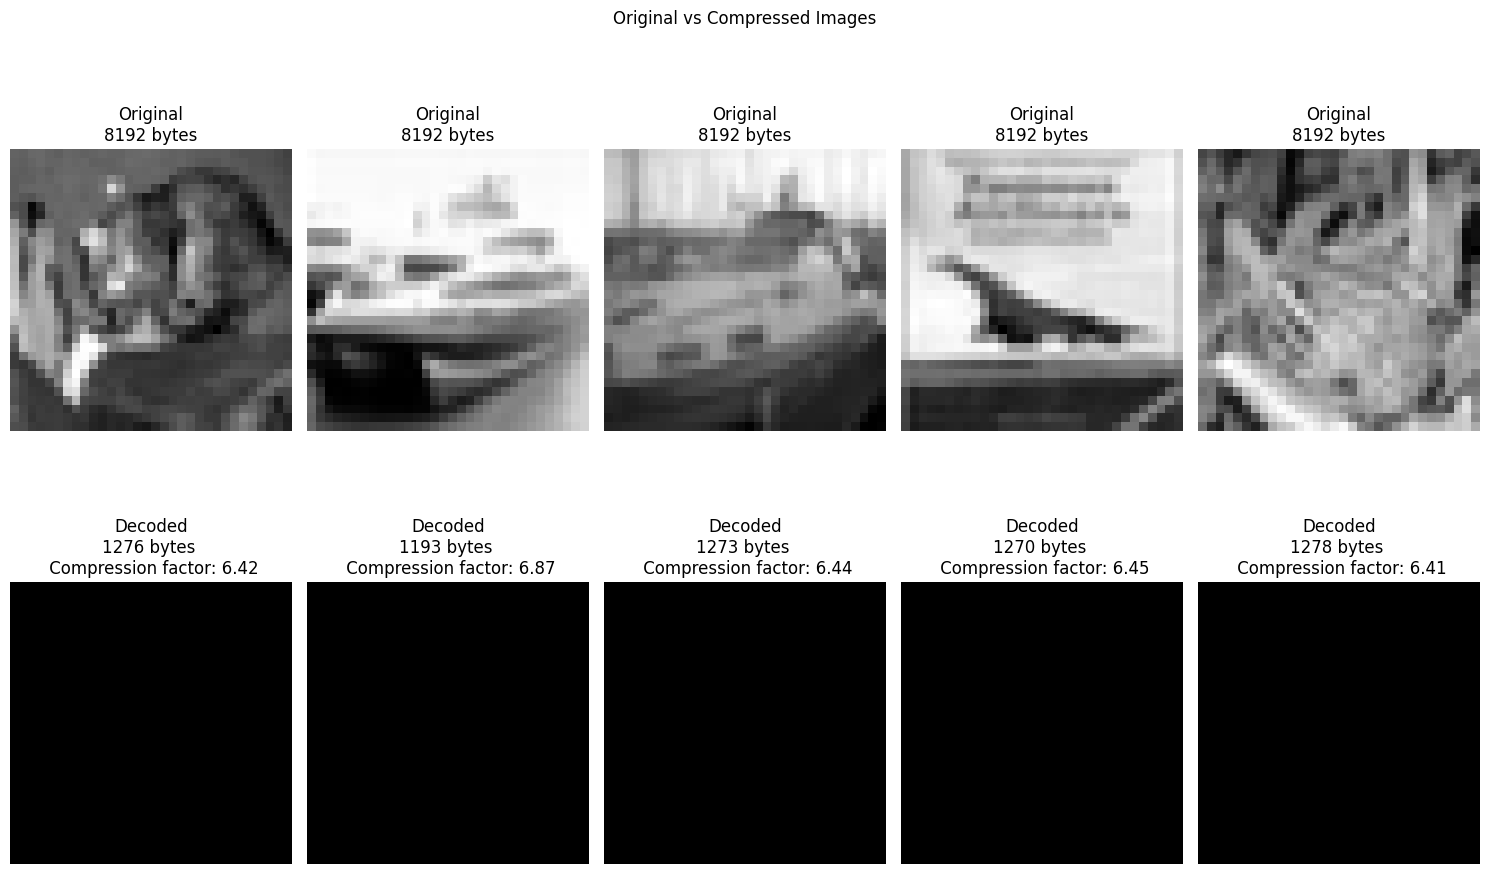

In [ ]:
plt.figure(figsize=(15, 10))
for i, img in enumerate(sample_images_gray):
    encoded_image, tree, shape = huffman_encoding(img)
    decoded_image = huffman_decoding(encoded_image, tree, shape)
    compression_factor = img.nbytes / (len(encoded_image)//8)

    plt.subplot(2, len(sample_images_gray), i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original\n{img.nbytes} bytes")
    plt.axis('off')

    plt.subplot(2, len(sample_images_gray), i + 1 + len(sample_images_gray))
    plt.imshow(decoded_image, cmap='gray')
    plt.title(f"Decoded\n{len(encoded_image) // 8} bytes \n Compression factor: {compression_factor:.2f}")
    plt.axis('off')

plt.suptitle(f"Original vs Compressed Images")
plt.tight_layout()
plt.show()